In [3]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils import *

## Load Processed Data

In [4]:
x, y, xtest, ytest, samples_per_machine, true = np.load('data/per record data.npy', allow_pickle=True)

## Random Forest Regressor: Tuning

In [5]:
from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [6]:
def train_rf(xtrain, ytrain, **kwargs):
    model = RandomForestRegressor(**kwargs, criterion='squared_error', oob_score=mean_squared_error)
    model.fit(xtrain, ytrain)
    return kwargs, model.oob_score_

In [10]:
results = Parallel(n_jobs=-1)(
    delayed(train_rf)(xtrain=x, ytrain=y, n_estimators=n, max_features=maxFeat, max_depth=maxDepth, min_samples_leaf=minLeafSample)
    for n in [40, 70, 100, 120, 140] for maxFeat in [3, 4, 5, 6, 7, 8] for maxDepth in [1, 3, 5, 7, 9] for minLeafSample in [1, 4, 8, 12, 16]
)

parameters, errors = [], []
for hyperparameters, oob_error in results:
    parameters.append(hyperparameters)
    errors.append(oob_error)

min_idx = min(np.arange(len(errors)), key=lambda x: errors[x])
optimal_rf_parameters = parameters[min_idx]
print(f'Min error is {errors[min_idx]} with parameters: {optimal_rf_parameters}')

Min error is 328.82209555790547 with parameters: {'n_estimators': 140, 'max_features': 6, 'max_depth': 9, 'min_samples_leaf': 8}


In [11]:
# graphing code is in tuning.py
np.save('rf_parameters.npy', np.array([parameters, errors, optimal_rf_parameters], dtype=object))

## Best Random Forest Model

In [57]:
rf = RandomForestRegressor(n_estimators=optimal_rf_parameters['n_estimators'], 
                           criterion='squared_error', 
                           max_depth=optimal_rf_parameters['max_depth'], 
                           min_samples_leaf=optimal_rf_parameters['min_samples_leaf'], 
                           max_features=optimal_rf_parameters['max_features'], 
                           oob_score=mean_squared_error)
print(f'Training OOB score: {rf.fit(x, y).oob_score_}')

Training OOB score: 329.60222419888424


In [58]:
# performance only using average of test predictions per engine
rf_mean_predictions = metrics(model=rf, xtest=xtest, true=true, y_per_engine=samples_per_machine, mean_metrics=True)

MSE:  371.4459038678938
RMSE:  19.27293189600103
MAE:  14.406113239152328
R2:  0.7849021698755402


In [59]:
# performance only using the last test record per engine
rf_final_predictions = metrics(model=rf, xtest=xtest, true=true, y_per_engine=samples_per_machine, mean_metrics=False)

MSE (Taking only last sample):  316.3018274927062
RMSE (Taking only last sample):  17.784876369902214
MAE (Taking only last sample):  12.932193006486365
R2 (Taking only last sample):  0.8168351405961942


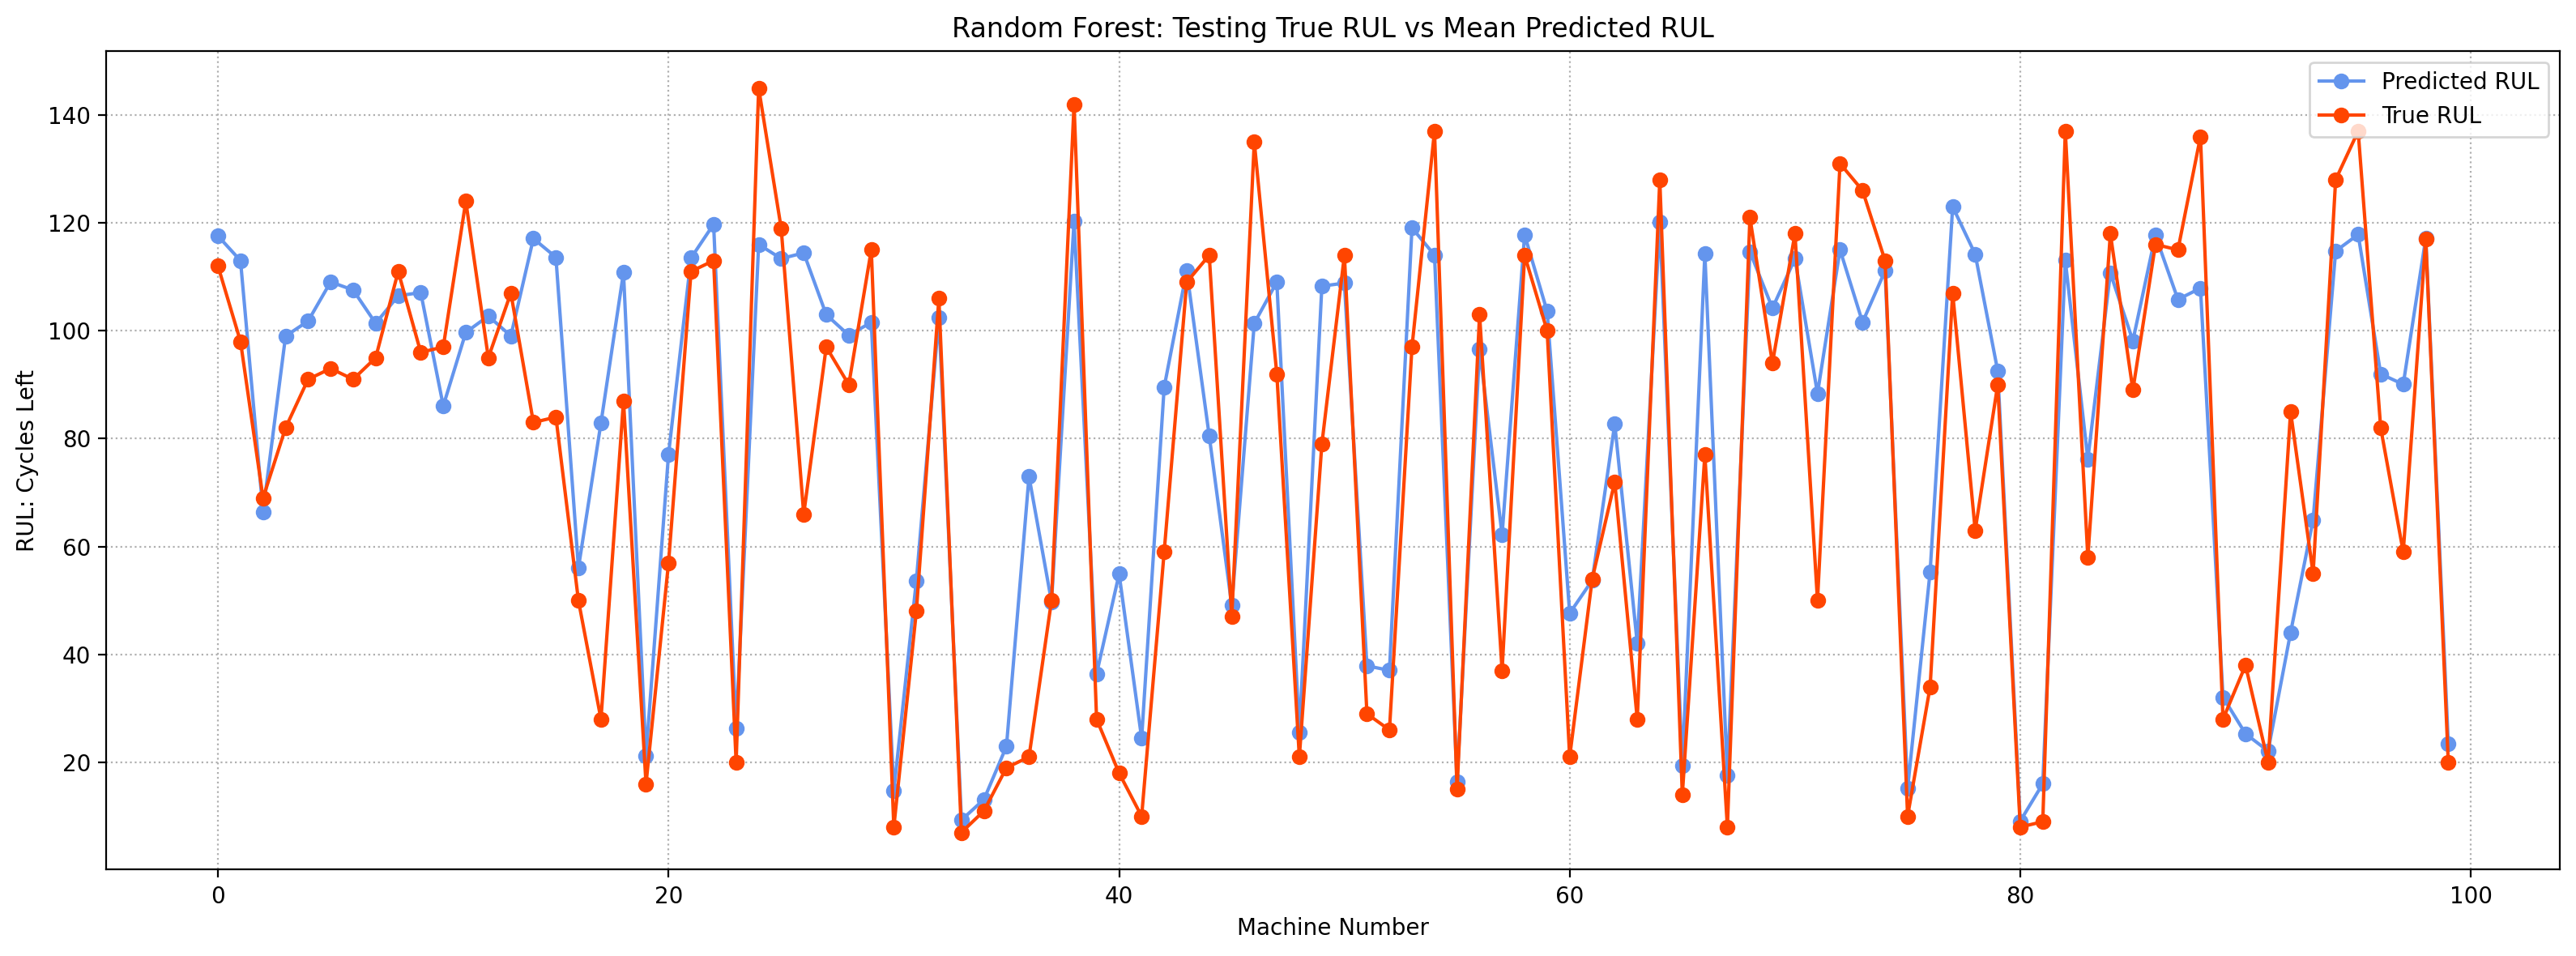

In [60]:
fig, ax = test_plot(model_name='Random Forest', predictions=rf_mean_predictions, true=true)

## XGBoost: Tuning Tree Parameters & Learning Rate

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

In [32]:
lr = 0.2
hyperparameters = {'n_estimators': [40, 70, 100, 120, 140, 170, 200], 
                   'max_depth': [1, 2, 3, 5, 6, 7],
                   'min_child_weight': [5, 10, 20, 50, 75, 100]}
grid_search = GridSearchCV(estimator=XGBRegressor(eta=lr, objective='reg:squarederror'), param_grid=hyperparameters, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(x, y)

parameters, errors = [], []
for hyperparameters, kfold_error in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    parameters.append(hyperparameters)
    errors.append(-1*kfold_error)
    
min_idx = min(np.arange(len(errors)), key=lambda x: errors[x])
optimal_xgb_parameters = parameters[min_idx]
print(f'Min mean K-Fold validation error is {errors[min_idx]} with parameters: {optimal_xgb_parameters}')

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Min mean K-Fold validation error is 346.9487947796323 with parameters: {'max_depth': 3, 'min_child_weight': 50, 'n_estimators': 140}


In [33]:
# graphing code is in tuning.py
np.save('xgb_parameters.npy', np.array([parameters, errors, lr, optimal_xgb_parameters], dtype=object))

In [34]:
# tune learning rate given the previous optimal tree-related optimal hyperparameters
lrs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1]

kfold = KFold(n_splits=5, shuffle=True)
train_curves, val_curves, losses = [], [], []
for lr in lrs:
    train_mse, val_mse = [], []
    for train_idx, val_idx in kfold.split(x, y):
        model = XGBRegressor(n_estimators=optimal_xgb_parameters['n_estimators'], 
                             objective='reg:squarederror', 
                             max_depth=optimal_xgb_parameters['max_depth'], 
                             min_child_weight=optimal_xgb_parameters['min_child_weight'], eta=lr)
        model.fit(x[train_idx], y[train_idx], eval_set=[(x[train_idx], y[train_idx]), (x[val_idx], y[val_idx])], verbose=0)
        train_mse.append(np.array(model.evals_result_['validation_0']['rmse'])**2)
        val_mse.append(np.array(model.evals_result_['validation_1']['rmse'])**2)
    train_curves.append(np.average(train_mse, axis=0))
    val_mse = np.average(val_mse, axis=0)
    val_curves.append(val_mse)
    losses.append(val_mse[-1])

min_idx = min(np.arange(len(losses)), key=lambda x: losses[x])
optimal_xgb_parameters['eta'] = lrs[min_idx]
print(f'Min mean K-Fold validation error is {losses[min_idx]} with learning rate: {optimal_xgb_parameters["eta"]}')

Min mean K-Fold validation error is 330.9863412779621 with learning rate: 0.1


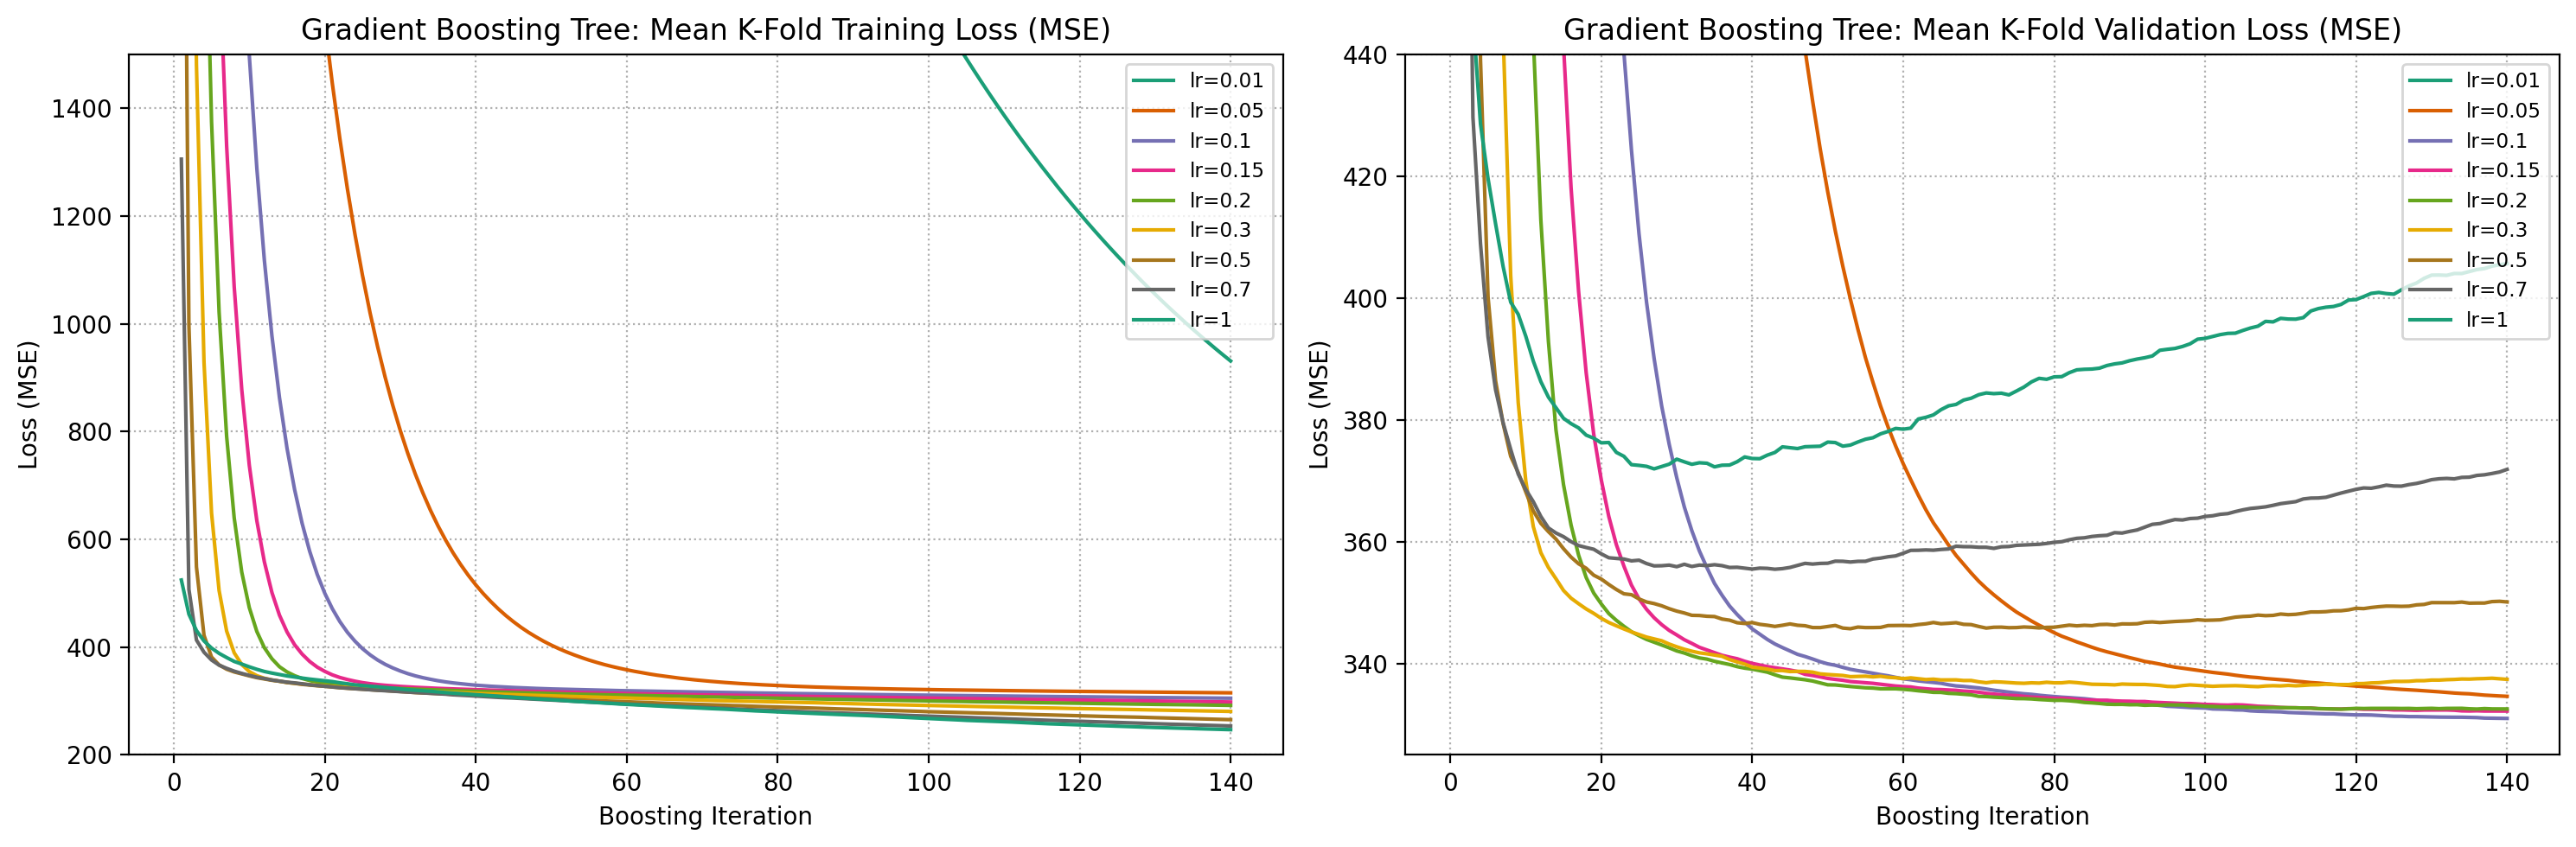

In [35]:
# plot training curves from different lrs
sns.set_palette('Dark2', 10)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=200)
lrs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7, 1]
iterations = np.arange(1, 141)
for i, lr in enumerate(lrs):
    axes[0].plot(iterations, train_curves[i], label=f'lr={lr}')
    axes[1].plot(iterations, val_curves[i], label=f'lr={lr}')
    
for ax in axes:
    ax.set_xlabel('Boosting Iteration')
    ax.set_ylabel('Loss (MSE)')
    ax.grid(linestyle=':')
axes[0].set_title('Gradient Boosting Tree: Mean K-Fold Training Loss (MSE)')
axes[1].set_title('Gradient Boosting Tree: Mean K-Fold Validation Loss (MSE)')
axes[0].set_ylim((200, 1500))
axes[1].set_ylim((325, 440))
axes[0].legend(loc='upper right', fontsize='small')
axes[1].legend(loc='upper right', fontsize='small')
fig.tight_layout()
plt.show()

## Best XGBRegressor Model

In [61]:
gbt = XGBRegressor(n_estimators=optimal_xgb_parameters['n_estimators'], 
                   objective='reg:squarederror', 
                   max_depth=optimal_xgb_parameters['max_depth'], 
                   min_child_weight=optimal_xgb_parameters['min_child_weight'], 
                   eta=optimal_xgb_parameters['eta'])
xtrain, xval, ytrain, yval = train_test_split(x, y)
gbt.fit(xtrain, ytrain, eval_set=[(xtrain, ytrain), (xval, yval)], verbose=0)
print(f'Validation MSE: {gbt.evals_result_["validation_0"]["rmse"][-1]**2}')

Validation MSE: 302.7705312653831


In [65]:
# performance only using average of test predictions per engine
gbt_mean_predictions = metrics(model=gbt, xtest=xtest, true=true, y_per_engine=samples_per_machine, mean_metrics=True)

MSE:  380.76501551901646
RMSE:  19.513201057720295
MAE:  14.136588592529296
R2:  0.7795056352147165


In [66]:
# performance only using the last test record per engine
gbt_final_predictions = metrics(model=model, xtest=xtest, true=true, y_per_engine=samples_per_machine, mean_metrics=False)

MSE (Taking only last sample):  322.67626425407195
RMSE (Taking only last sample):  17.963191928331444
MAE (Taking only last sample):  13.135877332778001
R2 (Taking only last sample):  0.8131438156916585


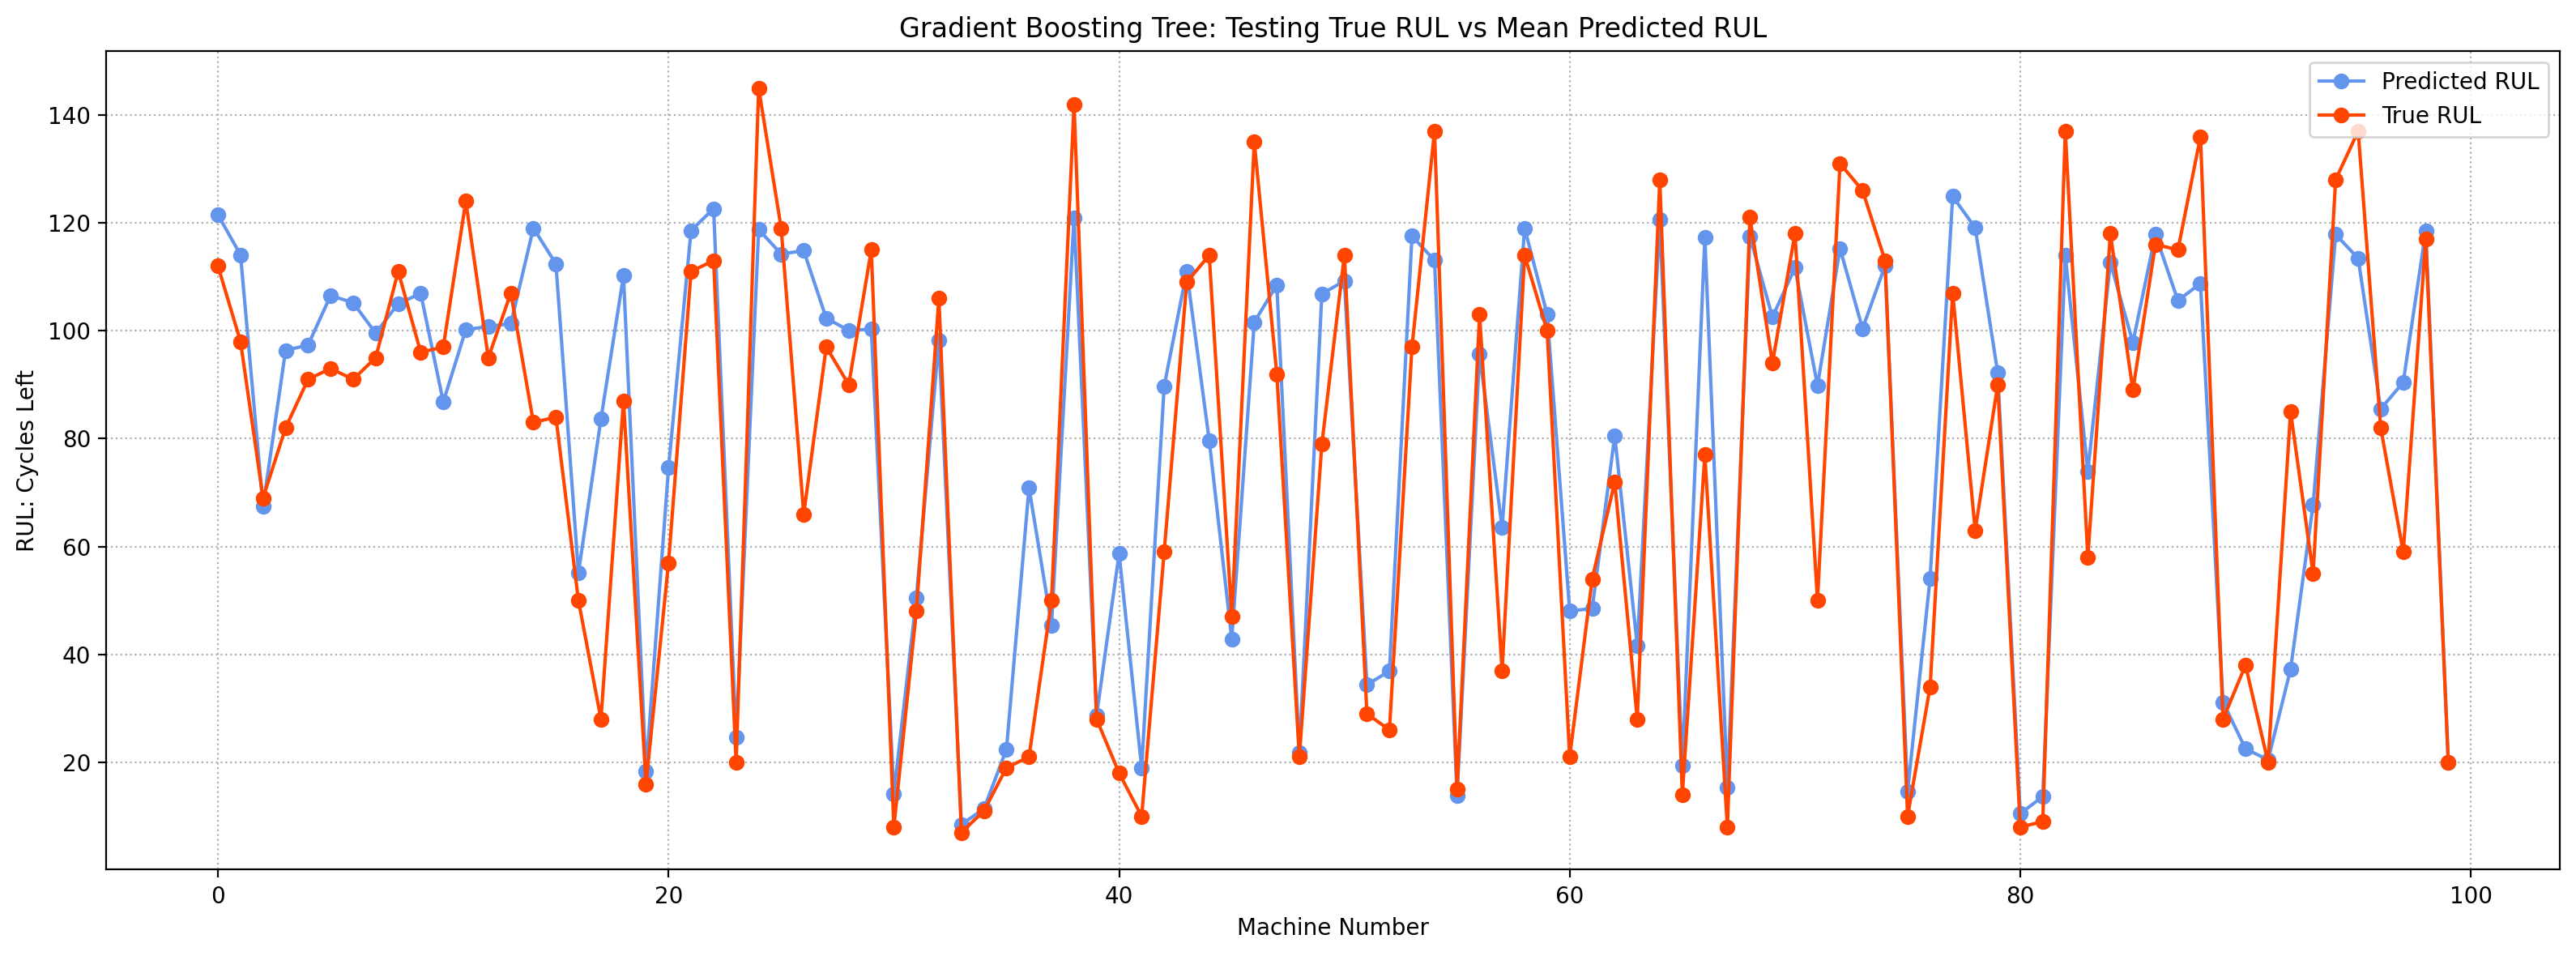

In [67]:
fig, ax = test_plot(model_name='Gradient Boosting Tree', predictions=gbt_mean_predictions, true=true)